In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X,layers):
        
        # boundary conditions
        self.k_hl = torch.tensor([40]).float().to(device)
        self.Pl_A = torch.tensor([20]).float().to(device)
        
        # data
        self.x  = torch.tensor(X, requires_grad=True).float().to(device)
    
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.lr = 0.01
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=self.lr, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x):  
        u = self.dnn(x)
        return u
    
    def net_f(self, x):
        k_hl = self.k_hl
        Pl_A = self.Pl_A
        
        nn = self.net_u(x)
        
        nn_x = torch.autograd.grad(
            nn, x, 
            grad_outputs=torch.ones_like(nn),
            retain_graph=True,
            create_graph=True
        )[0]
        nn_xx = torch.autograd.grad(
            nn_x, x, 
            grad_outputs=torch.ones_like(nn_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        theta_xx = -2*nn + (2-4*x)*nn_x + x*(1-x)*nn_xx
        theta = (1-x) + ((k_hl)/(k_hl-1))*(self.net_u(x[-1:,:])+1) + x*(1-x)*nn
        f = (k_hl/Pl_A)*theta_xx - theta
        return f


    def loss_func(self):
        f = self.net_f(self.x)

        loss = torch.mean(torch.square(f)) 
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
#         if self.iter % 100 == 0:
#             print('Loss: %e' % (loss.item(),))
        return loss
    
    def train(self, nIter,lr):
        self.dnn.train()
        self.lr = lr
        for epoch in range(nIter):
            f = self.net_f(self.x)
            loss = torch.mean(torch.square(f)) 
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 1== 0:
                print(
                    'It: %d, Loss: %.3e' % 
                    (
                        epoch, 
                        loss.item(), 
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.dnn.eval()
        nn = self.net_u(x)
        theta = (1-x) + ((self.k_hl)/(self.k_hl-1))*(self.net_u(x[-1:,:])+1)*x + x*(1-x)*nn
        return theta.detach().cpu().numpy()

In [5]:
N_u = 101
layers = [1,8,8,8,8,1]

x = np.arange(0,1.01,0.01).reshape(-1,1) 
model = PhysicsInformedNN(x,layers)

In [7]:
model.train(10000,0.01)

It: 0, Loss: 8.851e-08
It: 1, Loss: 9.516e-08
It: 2, Loss: 1.139e-07
It: 3, Loss: 1.458e-07
It: 4, Loss: 1.947e-07
It: 5, Loss: 2.690e-07
It: 6, Loss: 3.821e-07
It: 7, Loss: 5.563e-07
It: 8, Loss: 8.261e-07
It: 9, Loss: 1.247e-06
It: 10, Loss: 1.907e-06
It: 11, Loss: 2.943e-06
It: 12, Loss: 4.564e-06
It: 13, Loss: 7.082e-06
It: 14, Loss: 1.091e-05
It: 15, Loss: 1.654e-05
It: 16, Loss: 2.428e-05
It: 17, Loss: 3.388e-05
It: 18, Loss: 4.346e-05
It: 19, Loss: 4.924e-05
It: 20, Loss: 4.627e-05
It: 21, Loss: 3.313e-05
It: 22, Loss: 1.514e-05
It: 23, Loss: 2.341e-06
It: 24, Loss: 9.412e-07
It: 25, Loss: 8.671e-06
It: 26, Loss: 1.746e-05
It: 27, Loss: 1.969e-05
It: 28, Loss: 1.374e-05
It: 29, Loss: 4.835e-06
It: 30, Loss: 1.773e-07
It: 31, Loss: 2.246e-06
It: 32, Loss: 7.403e-06
It: 33, Loss: 1.007e-05
It: 34, Loss: 7.818e-06
It: 35, Loss: 3.081e-06
It: 36, Loss: 2.029e-07
It: 37, Loss: 1.097e-06
It: 38, Loss: 3.898e-06
It: 39, Loss: 5.376e-06
It: 40, Loss: 4.136e-06
It: 41, Loss: 1.582e-06
It

It: 350, Loss: 8.231e-08
It: 351, Loss: 8.255e-08
It: 352, Loss: 8.299e-08
It: 353, Loss: 8.321e-08
It: 354, Loss: 8.307e-08
It: 355, Loss: 8.268e-08
It: 356, Loss: 8.228e-08
It: 357, Loss: 8.209e-08
It: 358, Loss: 8.214e-08
It: 359, Loss: 8.230e-08
It: 360, Loss: 8.244e-08
It: 361, Loss: 8.243e-08
It: 362, Loss: 8.229e-08
It: 363, Loss: 8.210e-08
It: 364, Loss: 8.193e-08
It: 365, Loss: 8.186e-08
It: 366, Loss: 8.187e-08
It: 367, Loss: 8.192e-08
It: 368, Loss: 8.196e-08
It: 369, Loss: 8.194e-08
It: 370, Loss: 8.188e-08
It: 371, Loss: 8.179e-08
It: 372, Loss: 8.170e-08
It: 373, Loss: 8.164e-08
It: 374, Loss: 8.160e-08
It: 375, Loss: 8.161e-08
It: 376, Loss: 8.162e-08
It: 377, Loss: 8.162e-08
It: 378, Loss: 8.159e-08
It: 379, Loss: 8.153e-08
It: 380, Loss: 8.146e-08
It: 381, Loss: 8.142e-08
It: 382, Loss: 8.139e-08
It: 383, Loss: 8.137e-08
It: 384, Loss: 8.136e-08
It: 385, Loss: 8.135e-08
It: 386, Loss: 8.133e-08
It: 387, Loss: 8.130e-08
It: 388, Loss: 8.125e-08
It: 389, Loss: 8.122e-08


It: 729, Loss: 7.536e-08
It: 730, Loss: 7.550e-08
It: 731, Loss: 7.567e-08
It: 732, Loss: 7.593e-08
It: 733, Loss: 7.633e-08
It: 734, Loss: 7.690e-08
It: 735, Loss: 7.772e-08
It: 736, Loss: 7.890e-08
It: 737, Loss: 8.062e-08
It: 738, Loss: 8.312e-08
It: 739, Loss: 8.679e-08
It: 740, Loss: 9.228e-08
It: 741, Loss: 1.005e-07
It: 742, Loss: 1.130e-07
It: 743, Loss: 1.321e-07
It: 744, Loss: 1.612e-07
It: 745, Loss: 2.061e-07
It: 746, Loss: 2.761e-07
It: 747, Loss: 3.858e-07
It: 748, Loss: 5.582e-07
It: 749, Loss: 8.306e-07
It: 750, Loss: 1.263e-06
It: 751, Loss: 1.953e-06
It: 752, Loss: 3.051e-06
It: 753, Loss: 4.794e-06
It: 754, Loss: 7.526e-06
It: 755, Loss: 1.173e-05
It: 756, Loss: 1.793e-05
It: 757, Loss: 2.649e-05
It: 758, Loss: 3.690e-05
It: 759, Loss: 4.689e-05
It: 760, Loss: 5.167e-05
It: 761, Loss: 4.625e-05
It: 762, Loss: 3.017e-05
It: 763, Loss: 1.134e-05
It: 764, Loss: 7.107e-07
It: 765, Loss: 2.845e-06
It: 766, Loss: 1.266e-05
It: 767, Loss: 2.041e-05
It: 768, Loss: 1.932e-05


It: 1101, Loss: 7.039e-08
It: 1102, Loss: 7.005e-08
It: 1103, Loss: 7.000e-08
It: 1104, Loss: 7.015e-08
It: 1105, Loss: 7.037e-08
It: 1106, Loss: 7.048e-08
It: 1107, Loss: 7.044e-08
It: 1108, Loss: 7.024e-08
It: 1109, Loss: 7.001e-08
It: 1110, Loss: 6.985e-08
It: 1111, Loss: 6.980e-08
It: 1112, Loss: 6.983e-08
It: 1113, Loss: 6.992e-08
It: 1114, Loss: 6.998e-08
It: 1115, Loss: 6.997e-08
It: 1116, Loss: 6.988e-08
It: 1117, Loss: 6.977e-08
It: 1118, Loss: 6.967e-08
It: 1119, Loss: 6.961e-08
It: 1120, Loss: 6.960e-08
It: 1121, Loss: 6.961e-08
It: 1122, Loss: 6.963e-08
It: 1123, Loss: 6.964e-08
It: 1124, Loss: 6.961e-08
It: 1125, Loss: 6.956e-08
It: 1126, Loss: 6.950e-08
It: 1127, Loss: 6.944e-08
It: 1128, Loss: 6.942e-08
It: 1129, Loss: 6.940e-08
It: 1130, Loss: 6.939e-08
It: 1131, Loss: 6.940e-08
It: 1132, Loss: 6.938e-08
It: 1133, Loss: 6.936e-08
It: 1134, Loss: 6.933e-08
It: 1135, Loss: 6.929e-08
It: 1136, Loss: 6.926e-08
It: 1137, Loss: 6.923e-08
It: 1138, Loss: 6.921e-08
It: 1139, Lo

It: 1437, Loss: 6.528e-08
It: 1438, Loss: 6.530e-08
It: 1439, Loss: 6.533e-08
It: 1440, Loss: 6.540e-08
It: 1441, Loss: 6.548e-08
It: 1442, Loss: 6.561e-08
It: 1443, Loss: 6.578e-08
It: 1444, Loss: 6.605e-08
It: 1445, Loss: 6.640e-08
It: 1446, Loss: 6.689e-08
It: 1447, Loss: 6.759e-08
It: 1448, Loss: 6.857e-08
It: 1449, Loss: 6.997e-08
It: 1450, Loss: 7.197e-08
It: 1451, Loss: 7.487e-08
It: 1452, Loss: 7.907e-08
It: 1453, Loss: 8.521e-08
It: 1454, Loss: 9.427e-08
It: 1455, Loss: 1.077e-07
It: 1456, Loss: 1.280e-07
It: 1457, Loss: 1.586e-07
It: 1458, Loss: 2.053e-07
It: 1459, Loss: 2.770e-07
It: 1460, Loss: 3.875e-07
It: 1461, Loss: 5.589e-07
It: 1462, Loss: 8.262e-07
It: 1463, Loss: 1.245e-06
It: 1464, Loss: 1.902e-06
It: 1465, Loss: 2.933e-06
It: 1466, Loss: 4.546e-06
It: 1467, Loss: 7.038e-06
It: 1468, Loss: 1.082e-05
It: 1469, Loss: 1.632e-05
It: 1470, Loss: 2.385e-05
It: 1471, Loss: 3.299e-05
It: 1472, Loss: 4.190e-05
It: 1473, Loss: 4.669e-05
It: 1474, Loss: 4.305e-05
It: 1475, Lo

It: 1774, Loss: 7.652e-08
It: 1775, Loss: 6.573e-08
It: 1776, Loss: 6.245e-08
It: 1777, Loss: 6.701e-08
It: 1778, Loss: 7.357e-08
It: 1779, Loss: 7.599e-08
It: 1780, Loss: 7.261e-08
It: 1781, Loss: 6.664e-08
It: 1782, Loss: 6.263e-08
It: 1783, Loss: 6.282e-08
It: 1784, Loss: 6.593e-08
It: 1785, Loss: 6.880e-08
It: 1786, Loss: 6.907e-08
It: 1787, Loss: 6.674e-08
It: 1788, Loss: 6.375e-08
It: 1789, Loss: 6.213e-08
It: 1790, Loss: 6.256e-08
It: 1791, Loss: 6.419e-08
It: 1792, Loss: 6.544e-08
It: 1793, Loss: 6.538e-08
It: 1794, Loss: 6.415e-08
It: 1795, Loss: 6.269e-08
It: 1796, Loss: 6.192e-08
It: 1797, Loss: 6.214e-08
It: 1798, Loss: 6.291e-08
It: 1799, Loss: 6.356e-08
It: 1800, Loss: 6.361e-08
It: 1801, Loss: 6.308e-08
It: 1802, Loss: 6.233e-08
It: 1803, Loss: 6.183e-08
It: 1804, Loss: 6.178e-08
It: 1805, Loss: 6.207e-08
It: 1806, Loss: 6.242e-08
It: 1807, Loss: 6.256e-08
It: 1808, Loss: 6.241e-08
It: 1809, Loss: 6.209e-08
It: 1810, Loss: 6.177e-08
It: 1811, Loss: 6.160e-08
It: 1812, Lo

It: 2110, Loss: 5.842e-08
It: 2111, Loss: 5.840e-08
It: 2112, Loss: 5.839e-08
It: 2113, Loss: 5.838e-08
It: 2114, Loss: 5.837e-08
It: 2115, Loss: 5.836e-08
It: 2116, Loss: 5.835e-08
It: 2117, Loss: 5.833e-08
It: 2118, Loss: 5.832e-08
It: 2119, Loss: 5.830e-08
It: 2120, Loss: 5.829e-08
It: 2121, Loss: 5.828e-08
It: 2122, Loss: 5.825e-08
It: 2123, Loss: 5.824e-08
It: 2124, Loss: 5.823e-08
It: 2125, Loss: 5.822e-08
It: 2126, Loss: 5.820e-08
It: 2127, Loss: 5.818e-08
It: 2128, Loss: 5.817e-08
It: 2129, Loss: 5.816e-08
It: 2130, Loss: 5.816e-08
It: 2131, Loss: 5.814e-08
It: 2132, Loss: 5.813e-08
It: 2133, Loss: 5.812e-08
It: 2134, Loss: 5.810e-08
It: 2135, Loss: 5.810e-08
It: 2136, Loss: 5.809e-08
It: 2137, Loss: 5.808e-08
It: 2138, Loss: 5.807e-08
It: 2139, Loss: 5.806e-08
It: 2140, Loss: 5.806e-08
It: 2141, Loss: 5.804e-08
It: 2142, Loss: 5.803e-08
It: 2143, Loss: 5.803e-08
It: 2144, Loss: 5.802e-08
It: 2145, Loss: 5.801e-08
It: 2146, Loss: 5.800e-08
It: 2147, Loss: 5.800e-08
It: 2148, Lo

It: 2438, Loss: 5.834e-08
It: 2439, Loss: 1.687e-06
It: 2440, Loss: 4.295e-06
It: 2441, Loss: 4.984e-06
It: 2442, Loss: 3.206e-06
It: 2443, Loss: 8.630e-07
It: 2444, Loss: 7.430e-08
It: 2445, Loss: 1.105e-06
It: 2446, Loss: 2.471e-06
It: 2447, Loss: 2.668e-06
It: 2448, Loss: 1.592e-06
It: 2449, Loss: 3.796e-07
It: 2450, Loss: 9.219e-08
It: 2451, Loss: 7.266e-07
It: 2452, Loss: 1.424e-06
It: 2453, Loss: 1.439e-06
It: 2454, Loss: 8.163e-07
It: 2455, Loss: 1.923e-07
It: 2456, Loss: 8.977e-08
It: 2457, Loss: 4.529e-07
It: 2458, Loss: 8.127e-07
It: 2459, Loss: 7.985e-07
It: 2460, Loss: 4.568e-07
It: 2461, Loss: 1.269e-07
It: 2462, Loss: 7.445e-08
It: 2463, Loss: 2.665e-07
It: 2464, Loss: 4.604e-07
It: 2465, Loss: 4.616e-07
It: 2466, Loss: 2.862e-07
It: 2467, Loss: 1.047e-07
It: 2468, Loss: 6.133e-08
It: 2469, Loss: 1.535e-07
It: 2470, Loss: 2.630e-07
It: 2471, Loss: 2.812e-07
It: 2472, Loss: 1.997e-07
It: 2473, Loss: 9.754e-08
It: 2474, Loss: 5.651e-08
It: 2475, Loss: 9.190e-08
It: 2476, Lo

It: 2764, Loss: 5.401e-08
It: 2765, Loss: 5.414e-08
It: 2766, Loss: 5.425e-08
It: 2767, Loss: 5.428e-08
It: 2768, Loss: 5.420e-08
It: 2769, Loss: 5.406e-08
It: 2770, Loss: 5.393e-08
It: 2771, Loss: 5.386e-08
It: 2772, Loss: 5.386e-08
It: 2773, Loss: 5.390e-08
It: 2774, Loss: 5.395e-08
It: 2775, Loss: 5.396e-08
It: 2776, Loss: 5.394e-08
It: 2777, Loss: 5.386e-08
It: 2778, Loss: 5.380e-08
It: 2779, Loss: 5.375e-08
It: 2780, Loss: 5.374e-08
It: 2781, Loss: 5.374e-08
It: 2782, Loss: 5.377e-08
It: 2783, Loss: 5.377e-08
It: 2784, Loss: 5.376e-08
It: 2785, Loss: 5.373e-08
It: 2786, Loss: 5.370e-08
It: 2787, Loss: 5.366e-08
It: 2788, Loss: 5.363e-08
It: 2789, Loss: 5.362e-08
It: 2790, Loss: 5.362e-08
It: 2791, Loss: 5.362e-08
It: 2792, Loss: 5.363e-08
It: 2793, Loss: 5.362e-08
It: 2794, Loss: 5.361e-08
It: 2795, Loss: 5.358e-08
It: 2796, Loss: 5.355e-08
It: 2797, Loss: 5.353e-08
It: 2798, Loss: 5.351e-08
It: 2799, Loss: 5.350e-08
It: 2800, Loss: 5.348e-08
It: 2801, Loss: 5.347e-08
It: 2802, Lo

It: 3092, Loss: 5.194e-08
It: 3093, Loss: 5.194e-08
It: 3094, Loss: 5.192e-08
It: 3095, Loss: 5.191e-08
It: 3096, Loss: 5.190e-08
It: 3097, Loss: 5.189e-08
It: 3098, Loss: 5.189e-08
It: 3099, Loss: 5.187e-08
It: 3100, Loss: 5.186e-08
It: 3101, Loss: 5.186e-08
It: 3102, Loss: 5.184e-08
It: 3103, Loss: 5.183e-08
It: 3104, Loss: 5.182e-08
It: 3105, Loss: 5.181e-08
It: 3106, Loss: 5.179e-08
It: 3107, Loss: 5.178e-08
It: 3108, Loss: 5.178e-08
It: 3109, Loss: 5.176e-08
It: 3110, Loss: 5.175e-08
It: 3111, Loss: 5.175e-08
It: 3112, Loss: 5.174e-08
It: 3113, Loss: 5.173e-08
It: 3114, Loss: 5.172e-08
It: 3115, Loss: 5.171e-08
It: 3116, Loss: 5.171e-08
It: 3117, Loss: 5.168e-08
It: 3118, Loss: 5.168e-08
It: 3119, Loss: 5.168e-08
It: 3120, Loss: 5.166e-08
It: 3121, Loss: 5.165e-08
It: 3122, Loss: 5.165e-08
It: 3123, Loss: 5.163e-08
It: 3124, Loss: 5.162e-08
It: 3125, Loss: 5.161e-08
It: 3126, Loss: 5.161e-08
It: 3127, Loss: 5.160e-08
It: 3128, Loss: 5.159e-08
It: 3129, Loss: 5.158e-08
It: 3130, Lo

It: 3415, Loss: 5.025e-08
It: 3416, Loss: 5.024e-08
It: 3417, Loss: 5.024e-08
It: 3418, Loss: 5.023e-08
It: 3419, Loss: 5.022e-08
It: 3420, Loss: 5.021e-08
It: 3421, Loss: 5.020e-08
It: 3422, Loss: 5.019e-08
It: 3423, Loss: 5.019e-08
It: 3424, Loss: 5.019e-08
It: 3425, Loss: 5.018e-08
It: 3426, Loss: 5.017e-08
It: 3427, Loss: 5.017e-08
It: 3428, Loss: 5.016e-08
It: 3429, Loss: 5.016e-08
It: 3430, Loss: 5.016e-08
It: 3431, Loss: 5.015e-08
It: 3432, Loss: 5.015e-08
It: 3433, Loss: 5.014e-08
It: 3434, Loss: 5.015e-08
It: 3435, Loss: 5.014e-08
It: 3436, Loss: 5.015e-08
It: 3437, Loss: 5.014e-08
It: 3438, Loss: 5.014e-08
It: 3439, Loss: 5.014e-08
It: 3440, Loss: 5.014e-08
It: 3441, Loss: 5.014e-08
It: 3442, Loss: 5.014e-08
It: 3443, Loss: 5.014e-08
It: 3444, Loss: 5.014e-08
It: 3445, Loss: 5.017e-08
It: 3446, Loss: 5.017e-08
It: 3447, Loss: 5.021e-08
It: 3448, Loss: 5.025e-08
It: 3449, Loss: 5.029e-08
It: 3450, Loss: 5.037e-08
It: 3451, Loss: 5.046e-08
It: 3452, Loss: 5.058e-08
It: 3453, Lo

It: 3742, Loss: 2.429e-06
It: 3743, Loss: 2.764e-06
It: 3744, Loss: 1.707e-06
It: 3745, Loss: 4.184e-07
It: 3746, Loss: 8.031e-08
It: 3747, Loss: 7.359e-07
It: 3748, Loss: 1.468e-06
It: 3749, Loss: 1.472e-06
It: 3750, Loss: 8.036e-07
It: 3751, Loss: 1.657e-07
It: 3752, Loss: 1.020e-07
It: 3753, Loss: 5.090e-07
It: 3754, Loss: 8.613e-07
It: 3755, Loss: 7.912e-07
It: 3756, Loss: 4.049e-07
It: 3757, Loss: 8.961e-08
It: 3758, Loss: 9.478e-08
It: 3759, Loss: 3.257e-07
It: 3760, Loss: 4.997e-07
It: 3761, Loss: 4.442e-07
It: 3762, Loss: 2.327e-07
It: 3763, Loss: 6.896e-08
It: 3764, Loss: 7.525e-08
It: 3765, Loss: 1.983e-07
It: 3766, Loss: 2.921e-07
It: 3767, Loss: 2.667e-07
It: 3768, Loss: 1.563e-07
It: 3769, Loss: 6.441e-08
It: 3770, Loss: 5.896e-08
It: 3771, Loss: 1.203e-07
It: 3772, Loss: 1.756e-07
It: 3773, Loss: 1.723e-07
It: 3774, Loss: 1.186e-07
It: 3775, Loss: 6.450e-08
It: 3776, Loss: 5.109e-08
It: 3777, Loss: 7.773e-08
It: 3778, Loss: 1.111e-07
It: 3779, Loss: 1.191e-07
It: 3780, Lo

It: 4081, Loss: 4.841e-08
It: 4082, Loss: 4.840e-08
It: 4083, Loss: 4.836e-08
It: 4084, Loss: 4.833e-08
It: 4085, Loss: 4.831e-08
It: 4086, Loss: 4.830e-08
It: 4087, Loss: 4.830e-08
It: 4088, Loss: 4.830e-08
It: 4089, Loss: 4.829e-08
It: 4090, Loss: 4.829e-08
It: 4091, Loss: 4.827e-08
It: 4092, Loss: 4.825e-08
It: 4093, Loss: 4.824e-08
It: 4094, Loss: 4.822e-08
It: 4095, Loss: 4.821e-08
It: 4096, Loss: 4.821e-08
It: 4097, Loss: 4.821e-08
It: 4098, Loss: 4.820e-08
It: 4099, Loss: 4.819e-08
It: 4100, Loss: 4.818e-08
It: 4101, Loss: 4.817e-08
It: 4102, Loss: 4.816e-08
It: 4103, Loss: 4.815e-08
It: 4104, Loss: 4.814e-08
It: 4105, Loss: 4.813e-08
It: 4106, Loss: 4.813e-08
It: 4107, Loss: 4.813e-08
It: 4108, Loss: 4.811e-08
It: 4109, Loss: 4.810e-08
It: 4110, Loss: 4.809e-08
It: 4111, Loss: 4.808e-08
It: 4112, Loss: 4.806e-08
It: 4113, Loss: 4.808e-08
It: 4114, Loss: 4.806e-08
It: 4115, Loss: 4.805e-08
It: 4116, Loss: 4.804e-08
It: 4117, Loss: 4.804e-08
It: 4118, Loss: 4.803e-08
It: 4119, Lo

It: 4408, Loss: 4.730e-08
It: 4409, Loss: 4.729e-08
It: 4410, Loss: 4.729e-08
It: 4411, Loss: 4.727e-08
It: 4412, Loss: 4.727e-08
It: 4413, Loss: 4.727e-08
It: 4414, Loss: 4.726e-08
It: 4415, Loss: 4.725e-08
It: 4416, Loss: 4.725e-08
It: 4417, Loss: 4.725e-08
It: 4418, Loss: 4.724e-08
It: 4419, Loss: 4.724e-08
It: 4420, Loss: 4.723e-08
It: 4421, Loss: 4.723e-08
It: 4422, Loss: 4.721e-08
It: 4423, Loss: 4.721e-08
It: 4424, Loss: 4.721e-08
It: 4425, Loss: 4.720e-08
It: 4426, Loss: 4.719e-08
It: 4427, Loss: 4.719e-08
It: 4428, Loss: 4.719e-08
It: 4429, Loss: 4.718e-08
It: 4430, Loss: 4.718e-08
It: 4431, Loss: 4.716e-08
It: 4432, Loss: 4.716e-08
It: 4433, Loss: 4.716e-08
It: 4434, Loss: 4.715e-08
It: 4435, Loss: 4.715e-08
It: 4436, Loss: 4.713e-08
It: 4437, Loss: 4.713e-08
It: 4438, Loss: 4.713e-08
It: 4439, Loss: 4.712e-08
It: 4440, Loss: 4.712e-08
It: 4441, Loss: 4.712e-08
It: 4442, Loss: 4.711e-08
It: 4443, Loss: 4.711e-08
It: 4444, Loss: 4.711e-08
It: 4445, Loss: 4.711e-08
It: 4446, Lo

It: 4741, Loss: 2.074e-06
It: 4742, Loss: 1.066e-06
It: 4743, Loss: 9.006e-06
It: 4744, Loss: 1.731e-05
It: 4745, Loss: 1.842e-05
It: 4746, Loss: 1.153e-05
It: 4747, Loss: 3.071e-06
It: 4748, Loss: 8.552e-08
It: 4749, Loss: 3.585e-06
It: 4750, Loss: 8.542e-06
It: 4751, Loss: 9.511e-06
It: 4752, Loss: 5.764e-06
It: 4753, Loss: 1.287e-06
It: 4754, Loss: 1.682e-07
It: 4755, Loss: 2.497e-06
It: 4756, Loss: 4.997e-06
It: 4757, Loss: 4.861e-06
It: 4758, Loss: 2.426e-06
It: 4759, Loss: 3.128e-07
It: 4760, Loss: 3.589e-07
It: 4761, Loss: 1.909e-06
It: 4762, Loss: 2.944e-06
It: 4763, Loss: 2.355e-06
It: 4764, Loss: 8.927e-07
It: 4765, Loss: 6.130e-08
It: 4766, Loss: 4.591e-07
It: 4767, Loss: 1.348e-06
It: 4768, Loss: 1.649e-06
It: 4769, Loss: 1.087e-06
It: 4770, Loss: 3.067e-07
It: 4771, Loss: 5.689e-08
It: 4772, Loss: 4.217e-07
It: 4773, Loss: 8.681e-07
It: 4774, Loss: 8.914e-07
It: 4775, Loss: 5.029e-07
It: 4776, Loss: 1.199e-07
It: 4777, Loss: 7.733e-08
It: 4778, Loss: 3.186e-07
It: 4779, Lo

It: 5066, Loss: 9.597e-08
It: 5067, Loss: 4.985e-08
It: 5068, Loss: 1.021e-07
It: 5069, Loss: 1.399e-07
It: 5070, Loss: 9.665e-08
It: 5071, Loss: 5.041e-08
It: 5072, Loss: 6.997e-08
It: 5073, Loss: 1.055e-07
It: 5074, Loss: 9.161e-08
It: 5075, Loss: 5.520e-08
It: 5076, Loss: 5.429e-08
It: 5077, Loss: 7.976e-08
It: 5078, Loss: 8.271e-08
It: 5079, Loss: 5.964e-08
It: 5080, Loss: 4.905e-08
It: 5081, Loss: 6.267e-08
It: 5082, Loss: 7.232e-08
It: 5083, Loss: 6.156e-08
It: 5084, Loss: 4.921e-08
It: 5085, Loss: 5.314e-08
It: 5086, Loss: 6.273e-08
It: 5087, Loss: 6.077e-08
It: 5088, Loss: 5.123e-08
It: 5089, Loss: 4.904e-08
It: 5090, Loss: 5.519e-08
It: 5091, Loss: 5.779e-08
It: 5092, Loss: 5.276e-08
It: 5093, Loss: 4.842e-08
It: 5094, Loss: 5.049e-08
It: 5095, Loss: 5.406e-08
It: 5096, Loss: 5.295e-08
It: 5097, Loss: 4.921e-08
It: 5098, Loss: 4.846e-08
It: 5099, Loss: 5.081e-08
It: 5100, Loss: 5.183e-08
It: 5101, Loss: 4.992e-08
It: 5102, Loss: 4.814e-08
It: 5103, Loss: 4.879e-08
It: 5104, Lo

It: 5393, Loss: 8.585e-08
It: 5394, Loss: 1.144e-07
It: 5395, Loss: 1.639e-07
It: 5396, Loss: 2.502e-07
It: 5397, Loss: 4.018e-07
It: 5398, Loss: 6.696e-07
It: 5399, Loss: 1.144e-06
It: 5400, Loss: 1.985e-06
It: 5401, Loss: 3.479e-06
It: 5402, Loss: 6.109e-06
It: 5403, Loss: 1.068e-05
It: 5404, Loss: 1.832e-05
It: 5405, Loss: 3.036e-05
It: 5406, Loss: 4.693e-05
It: 5407, Loss: 6.461e-05
It: 5408, Loss: 7.312e-05
It: 5409, Loss: 6.095e-05
It: 5410, Loss: 3.024e-05
It: 5411, Loss: 4.174e-06
It: 5412, Loss: 2.731e-06
It: 5413, Loss: 2.016e-05
It: 5414, Loss: 3.308e-05
It: 5415, Loss: 2.581e-05
It: 5416, Loss: 7.639e-06
It: 5417, Loss: 1.449e-07
It: 5418, Loss: 8.771e-06
It: 5419, Loss: 1.822e-05
It: 5420, Loss: 1.483e-05
It: 5421, Loss: 3.971e-06
It: 5422, Loss: 2.782e-07
It: 5423, Loss: 6.308e-06
It: 5424, Loss: 1.110e-05
It: 5425, Loss: 7.420e-06
It: 5426, Loss: 1.145e-06
It: 5427, Loss: 8.385e-07
It: 5428, Loss: 5.164e-06
It: 5429, Loss: 6.577e-06
It: 5430, Loss: 3.086e-06
It: 5431, Lo

It: 5725, Loss: 4.592e-08
It: 5726, Loss: 4.610e-08
It: 5727, Loss: 4.638e-08
It: 5728, Loss: 4.686e-08
It: 5729, Loss: 4.767e-08
It: 5730, Loss: 4.903e-08
It: 5731, Loss: 5.133e-08
It: 5732, Loss: 5.524e-08
It: 5733, Loss: 6.201e-08
It: 5734, Loss: 7.372e-08
It: 5735, Loss: 9.415e-08
It: 5736, Loss: 1.299e-07
It: 5737, Loss: 1.932e-07
It: 5738, Loss: 3.054e-07
It: 5739, Loss: 5.057e-07
It: 5740, Loss: 8.644e-07
It: 5741, Loss: 1.509e-06
It: 5742, Loss: 2.668e-06
It: 5743, Loss: 4.745e-06
It: 5744, Loss: 8.423e-06
It: 5745, Loss: 1.479e-05
It: 5746, Loss: 2.524e-05
It: 5747, Loss: 4.089e-05
It: 5748, Loss: 6.002e-05
It: 5749, Loss: 7.490e-05
It: 5750, Loss: 7.147e-05
It: 5751, Loss: 4.439e-05
It: 5752, Loss: 1.152e-05
It: 5753, Loss: 2.893e-07
It: 5754, Loss: 1.480e-05
It: 5755, Loss: 3.277e-05
It: 5756, Loss: 3.144e-05
It: 5757, Loss: 1.275e-05
It: 5758, Loss: 2.400e-07
It: 5759, Loss: 6.500e-06
It: 5760, Loss: 1.824e-05
It: 5761, Loss: 1.749e-05
It: 5762, Loss: 5.935e-06
It: 5763, Lo

It: 6053, Loss: 4.574e-08
It: 6054, Loss: 4.574e-08
It: 6055, Loss: 4.573e-08
It: 6056, Loss: 4.574e-08
It: 6057, Loss: 4.572e-08
It: 6058, Loss: 4.573e-08
It: 6059, Loss: 4.572e-08
It: 6060, Loss: 4.573e-08
It: 6061, Loss: 4.572e-08
It: 6062, Loss: 4.571e-08
It: 6063, Loss: 4.572e-08
It: 6064, Loss: 4.571e-08
It: 6065, Loss: 4.571e-08
It: 6066, Loss: 4.571e-08
It: 6067, Loss: 4.571e-08
It: 6068, Loss: 4.570e-08
It: 6069, Loss: 4.571e-08
It: 6070, Loss: 4.569e-08
It: 6071, Loss: 4.570e-08
It: 6072, Loss: 4.569e-08
It: 6073, Loss: 4.570e-08
It: 6074, Loss: 4.568e-08
It: 6075, Loss: 4.569e-08
It: 6076, Loss: 4.568e-08
It: 6077, Loss: 4.568e-08
It: 6078, Loss: 4.567e-08
It: 6079, Loss: 4.568e-08
It: 6080, Loss: 4.567e-08
It: 6081, Loss: 4.567e-08
It: 6082, Loss: 4.567e-08
It: 6083, Loss: 4.567e-08
It: 6084, Loss: 4.566e-08
It: 6085, Loss: 4.567e-08
It: 6086, Loss: 4.565e-08
It: 6087, Loss: 4.566e-08
It: 6088, Loss: 4.565e-08
It: 6089, Loss: 4.566e-08
It: 6090, Loss: 4.565e-08
It: 6091, Lo

It: 6385, Loss: 4.714e-08
It: 6386, Loss: 4.714e-08
It: 6387, Loss: 4.712e-08
It: 6388, Loss: 4.711e-08
It: 6389, Loss: 4.709e-08
It: 6390, Loss: 4.709e-08
It: 6391, Loss: 4.708e-08
It: 6392, Loss: 4.706e-08
It: 6393, Loss: 4.706e-08
It: 6394, Loss: 4.705e-08
It: 6395, Loss: 4.703e-08
It: 6396, Loss: 4.702e-08
It: 6397, Loss: 4.701e-08
It: 6398, Loss: 4.701e-08
It: 6399, Loss: 4.700e-08
It: 6400, Loss: 4.698e-08
It: 6401, Loss: 4.697e-08
It: 6402, Loss: 4.696e-08
It: 6403, Loss: 4.696e-08
It: 6404, Loss: 4.694e-08
It: 6405, Loss: 4.694e-08
It: 6406, Loss: 4.693e-08
It: 6407, Loss: 4.692e-08
It: 6408, Loss: 4.691e-08
It: 6409, Loss: 4.690e-08
It: 6410, Loss: 4.689e-08
It: 6411, Loss: 4.688e-08
It: 6412, Loss: 4.687e-08
It: 6413, Loss: 4.687e-08
It: 6414, Loss: 4.686e-08
It: 6415, Loss: 4.685e-08
It: 6416, Loss: 4.685e-08
It: 6417, Loss: 4.684e-08
It: 6418, Loss: 4.682e-08
It: 6419, Loss: 4.681e-08
It: 6420, Loss: 4.681e-08
It: 6421, Loss: 4.680e-08
It: 6422, Loss: 4.679e-08
It: 6423, Lo

It: 6716, Loss: 5.761e-07
It: 6717, Loss: 8.872e-07
It: 6718, Loss: 1.387e-06
It: 6719, Loss: 2.193e-06
It: 6720, Loss: 3.486e-06
It: 6721, Loss: 5.545e-06
It: 6722, Loss: 8.760e-06
It: 6723, Loss: 1.362e-05
It: 6724, Loss: 2.051e-05
It: 6725, Loss: 2.931e-05
It: 6726, Loss: 3.835e-05
It: 6727, Loss: 4.397e-05
It: 6728, Loss: 4.120e-05
It: 6729, Loss: 2.866e-05
It: 6730, Loss: 1.197e-05
It: 6731, Loss: 1.199e-06
It: 6732, Loss: 1.702e-06
It: 6733, Loss: 9.944e-06
It: 6734, Loss: 1.730e-05
It: 6735, Loss: 1.704e-05
It: 6736, Loss: 9.661e-06
It: 6737, Loss: 1.987e-06
It: 6738, Loss: 3.028e-07
It: 6739, Loss: 4.384e-06
It: 6740, Loss: 8.773e-06
It: 6741, Loss: 8.731e-06
It: 6742, Loss: 4.571e-06
It: 6743, Loss: 6.748e-07
It: 6744, Loss: 4.509e-07
It: 6745, Loss: 3.073e-06
It: 6746, Loss: 5.071e-06
It: 6747, Loss: 4.253e-06
It: 6748, Loss: 1.703e-06
It: 6749, Loss: 9.865e-08
It: 6750, Loss: 6.840e-07
It: 6751, Loss: 2.256e-06
It: 6752, Loss: 2.854e-06
It: 6753, Loss: 1.893e-06
It: 6754, Lo

It: 7053, Loss: 4.976e-08
It: 7054, Loss: 4.797e-08
It: 7055, Loss: 4.756e-08
It: 7056, Loss: 4.841e-08
It: 7057, Loss: 4.963e-08
It: 7058, Loss: 5.030e-08
It: 7059, Loss: 5.006e-08
It: 7060, Loss: 4.913e-08
It: 7061, Loss: 4.808e-08
It: 7062, Loss: 4.746e-08
It: 7063, Loss: 4.746e-08
It: 7064, Loss: 4.789e-08
It: 7065, Loss: 4.840e-08
It: 7066, Loss: 4.861e-08
It: 7067, Loss: 4.844e-08
It: 7068, Loss: 4.801e-08
It: 7069, Loss: 4.754e-08
It: 7070, Loss: 4.729e-08
It: 7071, Loss: 4.729e-08
It: 7072, Loss: 4.746e-08
It: 7073, Loss: 4.766e-08
It: 7074, Loss: 4.777e-08
It: 7075, Loss: 4.772e-08
It: 7076, Loss: 4.756e-08
It: 7077, Loss: 4.735e-08
It: 7078, Loss: 4.720e-08
It: 7079, Loss: 4.713e-08
It: 7080, Loss: 4.717e-08
It: 7081, Loss: 4.725e-08
It: 7082, Loss: 4.734e-08
It: 7083, Loss: 4.737e-08
It: 7084, Loss: 4.732e-08
It: 7085, Loss: 4.725e-08
It: 7086, Loss: 4.714e-08
It: 7087, Loss: 4.707e-08
It: 7088, Loss: 4.702e-08
It: 7089, Loss: 4.702e-08
It: 7090, Loss: 4.705e-08
It: 7091, Lo

It: 7383, Loss: 4.728e-08
It: 7384, Loss: 4.728e-08
It: 7385, Loss: 4.727e-08
It: 7386, Loss: 4.725e-08
It: 7387, Loss: 4.725e-08
It: 7388, Loss: 4.723e-08
It: 7389, Loss: 4.723e-08
It: 7390, Loss: 4.723e-08
It: 7391, Loss: 4.720e-08
It: 7392, Loss: 4.720e-08
It: 7393, Loss: 4.719e-08
It: 7394, Loss: 4.718e-08
It: 7395, Loss: 4.718e-08
It: 7396, Loss: 4.717e-08
It: 7397, Loss: 4.716e-08
It: 7398, Loss: 4.716e-08
It: 7399, Loss: 4.714e-08
It: 7400, Loss: 4.714e-08
It: 7401, Loss: 4.713e-08
It: 7402, Loss: 4.712e-08
It: 7403, Loss: 4.712e-08
It: 7404, Loss: 4.711e-08
It: 7405, Loss: 4.710e-08
It: 7406, Loss: 4.709e-08
It: 7407, Loss: 4.708e-08
It: 7408, Loss: 4.707e-08
It: 7409, Loss: 4.707e-08
It: 7410, Loss: 4.707e-08
It: 7411, Loss: 4.706e-08
It: 7412, Loss: 4.705e-08
It: 7413, Loss: 4.704e-08
It: 7414, Loss: 4.704e-08
It: 7415, Loss: 4.703e-08
It: 7416, Loss: 4.703e-08
It: 7417, Loss: 4.702e-08
It: 7418, Loss: 4.702e-08
It: 7419, Loss: 4.700e-08
It: 7420, Loss: 4.699e-08
It: 7421, Lo

It: 7712, Loss: 4.710e-08
It: 7713, Loss: 4.709e-08
It: 7714, Loss: 4.709e-08
It: 7715, Loss: 4.709e-08
It: 7716, Loss: 4.707e-08
It: 7717, Loss: 4.707e-08
It: 7718, Loss: 4.707e-08
It: 7719, Loss: 4.706e-08
It: 7720, Loss: 4.706e-08
It: 7721, Loss: 4.705e-08
It: 7722, Loss: 4.705e-08
It: 7723, Loss: 4.704e-08
It: 7724, Loss: 4.704e-08
It: 7725, Loss: 4.703e-08
It: 7726, Loss: 4.703e-08
It: 7727, Loss: 4.702e-08
It: 7728, Loss: 4.702e-08
It: 7729, Loss: 4.702e-08
It: 7730, Loss: 4.700e-08
It: 7731, Loss: 4.701e-08
It: 7732, Loss: 4.700e-08
It: 7733, Loss: 4.700e-08
It: 7734, Loss: 4.698e-08
It: 7735, Loss: 4.699e-08
It: 7736, Loss: 4.698e-08
It: 7737, Loss: 4.698e-08
It: 7738, Loss: 4.698e-08
It: 7739, Loss: 4.697e-08
It: 7740, Loss: 4.696e-08
It: 7741, Loss: 4.696e-08
It: 7742, Loss: 4.697e-08
It: 7743, Loss: 4.697e-08
It: 7744, Loss: 4.696e-08
It: 7745, Loss: 4.695e-08
It: 7746, Loss: 4.696e-08
It: 7747, Loss: 4.695e-08
It: 7748, Loss: 4.695e-08
It: 7749, Loss: 4.694e-08
It: 7750, Lo

It: 8045, Loss: 4.733e-08
It: 8046, Loss: 4.732e-08
It: 8047, Loss: 4.733e-08
It: 8048, Loss: 4.732e-08
It: 8049, Loss: 4.731e-08
It: 8050, Loss: 4.731e-08
It: 8051, Loss: 4.730e-08
It: 8052, Loss: 4.730e-08
It: 8053, Loss: 4.730e-08
It: 8054, Loss: 4.729e-08
It: 8055, Loss: 4.730e-08
It: 8056, Loss: 4.729e-08
It: 8057, Loss: 4.729e-08
It: 8058, Loss: 4.729e-08
It: 8059, Loss: 4.728e-08
It: 8060, Loss: 4.728e-08
It: 8061, Loss: 4.727e-08
It: 8062, Loss: 4.727e-08
It: 8063, Loss: 4.728e-08
It: 8064, Loss: 4.726e-08
It: 8065, Loss: 4.726e-08
It: 8066, Loss: 4.726e-08
It: 8067, Loss: 4.726e-08
It: 8068, Loss: 4.725e-08
It: 8069, Loss: 4.725e-08
It: 8070, Loss: 4.725e-08
It: 8071, Loss: 4.725e-08
It: 8072, Loss: 4.725e-08
It: 8073, Loss: 4.725e-08
It: 8074, Loss: 4.724e-08
It: 8075, Loss: 4.725e-08
It: 8076, Loss: 4.724e-08
It: 8077, Loss: 4.724e-08
It: 8078, Loss: 4.724e-08
It: 8079, Loss: 4.722e-08
It: 8080, Loss: 4.722e-08
It: 8081, Loss: 4.723e-08
It: 8082, Loss: 4.722e-08
It: 8083, Lo

It: 8382, Loss: 4.745e-08
It: 8383, Loss: 4.745e-08
It: 8384, Loss: 4.745e-08
It: 8385, Loss: 4.745e-08
It: 8386, Loss: 4.746e-08
It: 8387, Loss: 4.748e-08
It: 8388, Loss: 4.752e-08
It: 8389, Loss: 4.758e-08
It: 8390, Loss: 4.767e-08
It: 8391, Loss: 4.783e-08
It: 8392, Loss: 4.807e-08
It: 8393, Loss: 4.847e-08
It: 8394, Loss: 4.916e-08
It: 8395, Loss: 5.028e-08
It: 8396, Loss: 5.215e-08
It: 8397, Loss: 5.531e-08
It: 8398, Loss: 6.071e-08
It: 8399, Loss: 6.996e-08
It: 8400, Loss: 8.591e-08
It: 8401, Loss: 1.136e-07
It: 8402, Loss: 1.618e-07
It: 8403, Loss: 2.464e-07
It: 8404, Loss: 3.960e-07
It: 8405, Loss: 6.619e-07
It: 8406, Loss: 1.135e-06
It: 8407, Loss: 1.980e-06
It: 8408, Loss: 3.483e-06
It: 8409, Loss: 6.140e-06
It: 8410, Loss: 1.075e-05
It: 8411, Loss: 1.846e-05
It: 8412, Loss: 3.040e-05
It: 8413, Loss: 4.652e-05
It: 8414, Loss: 6.240e-05
It: 8415, Loss: 6.784e-05
It: 8416, Loss: 5.244e-05
It: 8417, Loss: 2.259e-05
It: 8418, Loss: 1.649e-06
It: 8419, Loss: 4.971e-06
It: 8420, Lo

It: 8714, Loss: 4.794e-08
It: 8715, Loss: 4.802e-08
It: 8716, Loss: 4.814e-08
It: 8717, Loss: 4.831e-08
It: 8718, Loss: 4.858e-08
It: 8719, Loss: 4.899e-08
It: 8720, Loss: 4.961e-08
It: 8721, Loss: 5.055e-08
It: 8722, Loss: 5.200e-08
It: 8723, Loss: 5.423e-08
It: 8724, Loss: 5.769e-08
It: 8725, Loss: 6.309e-08
It: 8726, Loss: 7.157e-08
It: 8727, Loss: 8.493e-08
It: 8728, Loss: 1.061e-07
It: 8729, Loss: 1.400e-07
It: 8730, Loss: 1.946e-07
It: 8731, Loss: 2.828e-07
It: 8732, Loss: 4.265e-07
It: 8733, Loss: 6.619e-07
It: 8734, Loss: 1.049e-06
It: 8735, Loss: 1.687e-06
It: 8736, Loss: 2.737e-06
It: 8737, Loss: 4.458e-06
It: 8738, Loss: 7.233e-06
It: 8739, Loss: 1.159e-05
It: 8740, Loss: 1.810e-05
It: 8741, Loss: 2.698e-05
It: 8742, Loss: 3.713e-05
It: 8743, Loss: 4.519e-05
It: 8744, Loss: 4.536e-05
It: 8745, Loss: 3.418e-05
It: 8746, Loss: 1.599e-05
It: 8747, Loss: 2.297e-06
It: 8748, Loss: 1.201e-06
It: 8749, Loss: 9.947e-06
It: 8750, Loss: 1.853e-05
It: 8751, Loss: 1.846e-05
It: 8752, Lo

It: 9044, Loss: 5.374e-07
It: 9045, Loss: 4.599e-07
It: 9046, Loss: 2.167e-07
It: 9047, Loss: 5.806e-08
It: 9048, Loss: 1.043e-07
It: 9049, Loss: 2.533e-07
It: 9050, Loss: 3.244e-07
It: 9051, Loss: 2.494e-07
It: 9052, Loss: 1.156e-07
It: 9053, Loss: 5.101e-08
It: 9054, Loss: 9.356e-08
It: 9055, Loss: 1.730e-07
It: 9056, Loss: 1.990e-07
It: 9057, Loss: 1.500e-07
It: 9058, Loss: 7.932e-08
It: 9059, Loss: 5.060e-08
It: 9060, Loss: 7.700e-08
It: 9061, Loss: 1.190e-07
It: 9062, Loss: 1.310e-07
It: 9063, Loss: 1.040e-07
It: 9064, Loss: 6.624e-08
It: 9065, Loss: 5.033e-08
It: 9066, Loss: 6.335e-08
It: 9067, Loss: 8.582e-08
It: 9068, Loss: 9.407e-08
It: 9069, Loss: 8.161e-08
It: 9070, Loss: 6.131e-08
It: 9071, Loss: 5.036e-08
It: 9072, Loss: 5.480e-08
It: 9073, Loss: 6.659e-08
It: 9074, Loss: 7.319e-08
It: 9075, Loss: 6.900e-08
It: 9076, Loss: 5.866e-08
It: 9077, Loss: 5.092e-08
It: 9078, Loss: 5.081e-08
It: 9079, Loss: 5.624e-08
It: 9080, Loss: 6.119e-08
It: 9081, Loss: 6.122e-08
It: 9082, Lo

It: 9371, Loss: 5.134e-08
It: 9372, Loss: 5.094e-08
It: 9373, Loss: 5.039e-08
It: 9374, Loss: 5.026e-08
It: 9375, Loss: 5.055e-08
It: 9376, Loss: 5.076e-08
It: 9377, Loss: 5.059e-08
It: 9378, Loss: 5.025e-08
It: 9379, Loss: 5.008e-08
It: 9380, Loss: 5.020e-08
It: 9381, Loss: 5.035e-08
It: 9382, Loss: 5.032e-08
It: 9383, Loss: 5.012e-08
It: 9384, Loss: 4.997e-08
It: 9385, Loss: 4.996e-08
It: 9386, Loss: 5.005e-08
It: 9387, Loss: 5.008e-08
It: 9388, Loss: 5.000e-08
It: 9389, Loss: 4.987e-08
It: 9390, Loss: 4.982e-08
It: 9391, Loss: 4.985e-08
It: 9392, Loss: 4.988e-08
It: 9393, Loss: 4.986e-08
It: 9394, Loss: 4.978e-08
It: 9395, Loss: 4.972e-08
It: 9396, Loss: 4.970e-08
It: 9397, Loss: 4.972e-08
It: 9398, Loss: 4.972e-08
It: 9399, Loss: 4.968e-08
It: 9400, Loss: 4.964e-08
It: 9401, Loss: 4.960e-08
It: 9402, Loss: 4.959e-08
It: 9403, Loss: 4.959e-08
It: 9404, Loss: 4.958e-08
It: 9405, Loss: 4.955e-08
It: 9406, Loss: 4.952e-08
It: 9407, Loss: 4.950e-08
It: 9408, Loss: 4.950e-08
It: 9409, Lo

It: 9700, Loss: 5.158e-08
It: 9701, Loss: 5.087e-08
It: 9702, Loss: 5.019e-08
It: 9703, Loss: 4.986e-08
It: 9704, Loss: 4.994e-08
It: 9705, Loss: 5.027e-08
It: 9706, Loss: 5.059e-08
It: 9707, Loss: 5.069e-08
It: 9708, Loss: 5.052e-08
It: 9709, Loss: 5.018e-08
It: 9710, Loss: 4.987e-08
It: 9711, Loss: 4.970e-08
It: 9712, Loss: 4.973e-08
It: 9713, Loss: 4.988e-08
It: 9714, Loss: 5.003e-08
It: 9715, Loss: 5.007e-08
It: 9716, Loss: 5.000e-08
It: 9717, Loss: 4.984e-08
It: 9718, Loss: 4.968e-08
It: 9719, Loss: 4.958e-08
It: 9720, Loss: 4.958e-08
It: 9721, Loss: 4.962e-08
It: 9722, Loss: 4.969e-08
It: 9723, Loss: 4.974e-08
It: 9724, Loss: 4.972e-08
It: 9725, Loss: 4.966e-08
It: 9726, Loss: 4.958e-08
It: 9727, Loss: 4.951e-08
It: 9728, Loss: 4.947e-08
It: 9729, Loss: 4.944e-08
It: 9730, Loss: 4.945e-08
It: 9731, Loss: 4.948e-08
It: 9732, Loss: 4.949e-08
It: 9733, Loss: 4.950e-08
It: 9734, Loss: 4.946e-08
It: 9735, Loss: 4.944e-08
It: 9736, Loss: 4.941e-08
It: 9737, Loss: 4.937e-08
It: 9738, Lo

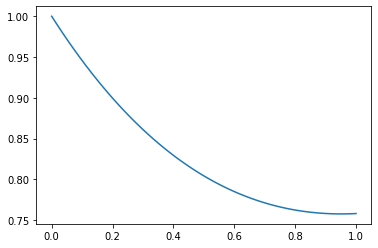

In [8]:
y_pred = model.predict(x)
plt.plot(x,y_pred)

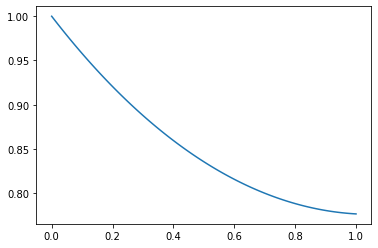

In [9]:
def convection_heat_transfer(k_hl,pl_A,x):
   return (np.cosh(np.sqrt(pl_A/k_hl)*(1-x))+ np.sqrt(1/(k_hl*pl_A))*np.sinh(np.sqrt(pl_A/k_hl)*(1-x)))/(np.cosh(np.sqrt(pl_A/k_hl))+np.sqrt(1/(k_hl*pl_A))*np.sinh(np.sqrt(pl_A/k_hl)))

y_actual = convection_heat_transfer(40,20,x)
plt.plot(x,y_actual)

In [14]:
from sklearn.metrics import r2_score
r2_score(y_pred,y_actual)

0.8797960214822096

In [15]:
r2_score(y_pred[:81,:],y_actual[:81,:])

0.8664012347732387

In [17]:
y_pred

array([[1.        ],
       [0.994192  ],
       [0.9884712 ],
       [0.98283696],
       [0.9772886 ],
       [0.97182554],
       [0.96644706],
       [0.9611526 ],
       [0.9559415 ],
       [0.95081294],
       [0.94576657],
       [0.9408015 ],
       [0.9359174 ],
       [0.93111336],
       [0.92638886],
       [0.92174333],
       [0.91717607],
       [0.9126865 ],
       [0.9082742 ],
       [0.90393823],
       [0.8996783 ],
       [0.8954936 ],
       [0.89138365],
       [0.8873478 ],
       [0.88338554],
       [0.8794963 ],
       [0.87567943],
       [0.8719344 ],
       [0.8682606 ],
       [0.8646576 ],
       [0.8611245 ],
       [0.8576612 ],
       [0.8542669 ],
       [0.85094106],
       [0.8476831 ],
       [0.84449255],
       [0.8413689 ],
       [0.8383116 ],
       [0.83532006],
       [0.8323937 ],
       [0.82953227],
       [0.8267349 ],
       [0.82400125],
       [0.8213307 ],
       [0.81872296],
       [0.81617737],
       [0.81369334],
       [0.811

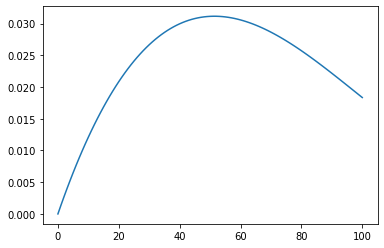

In [20]:
plt.plot(y_actual-y_pred)

In [21]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [22]:
MAPE(y_actual,y_pred)

0.02835776894145065